# Laboratorio 2 
# Regresión Lineal Regularizada 
## José Alejandro Guzmán Zamora 

In [1]:
"""Importar todas las librerías a utilizar, la librería que dice
gradientdescent es mi archivo de implementación del algoritmo. La 
librería de preprocessing es para la normalización y la de split 
es para hacer cross validation. """

import numpy as np 
import pandas as pd 
import seaborn as sns
import gradientdescent as gd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Obtener Datos y Exploración Inicial

In [2]:
"""Leer el archivo con la información, guardarlo en un dataframe
y el loop manda a imprimir todas las features involucradas. """

data_inicial = pd.read_csv('./admission.csv')
data_inicial.head()
for i in data_inicial:
    print(i)

Serial No.
GRE Score
TOEFL Score
University Rating
SOP
LOR 
CGPA
Research
Chance of Admit 


In [3]:
"""Información que Pandas nos provee del dataset. Se puede empezar a ver
los tipos de datos son float y entero, es decir, todas las variables tienen
datos numéricos."""

data_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [4]:
"""Comenzar a hacer la separación de la Response Variable, en este caso 
se va a intentar predecir la variable de Chance of Admit."""

no_usar = 'Chance of Admit '
data_continuar = data_inicial.drop(no_usar, 1)
data_continuar.head(1)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1


[]

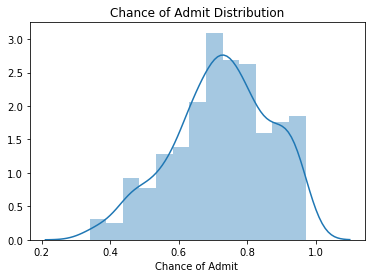

In [11]:
"""Verificar la distribución de la Response Variable, se puede ver que 
hay cierto sesgo hacia la izquierda."""

sns.distplot(data_inicial['Chance of Admit '])
plt.title("Chance of Admit Distribution")
plt.plot()

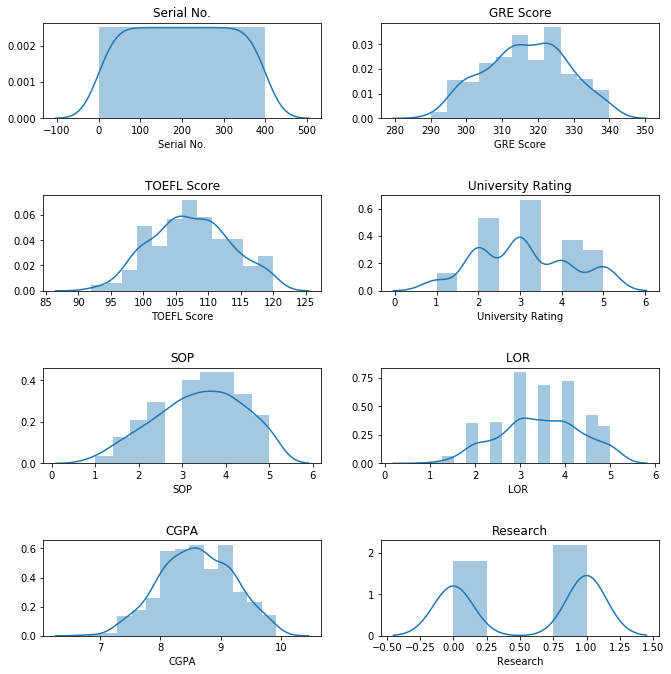

In [12]:
"""Visualización de las distribuciones de todas las variables, 
esto se hace con el objetivo de verificar si la distribución es normal, 
si hay outliers y sesgos. SOP y LOR son similares en el mínimo sesgo 
que tienen hacia la izquierda. Research no tiene distribución per se
pues es una variable de caracter binario."""

axis = []

cont = 1
fig = plt.figure(figsize=(10,10))
for i in data_continuar:
    axtemp = fig.add_subplot(4,2,cont)
    fig.tight_layout(pad=3.0)
    sns.distplot(data_continuar[i])
    plt.title(i)
    cont += 1

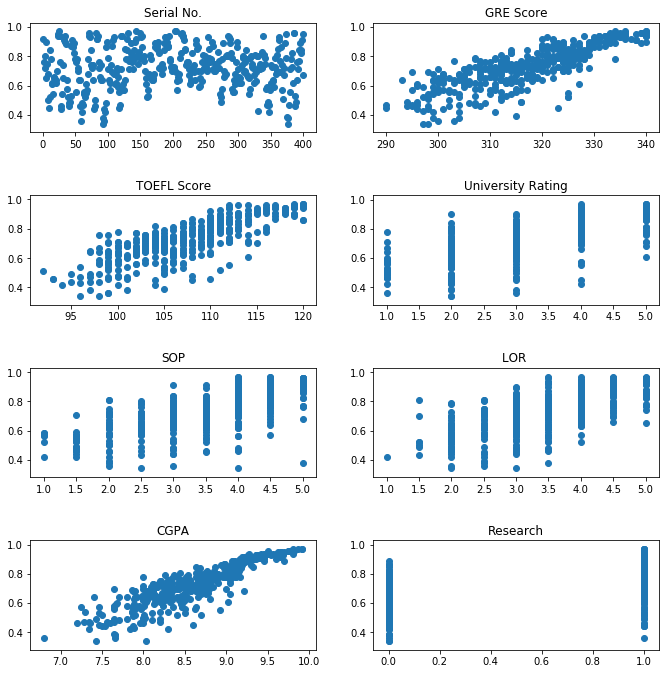

In [13]:
"""Visualización de la distribución de cada una de las variables contra
la Response Variable de Chance of Admit. El número de serial obviamente no va a
tener una relación. GRE tiene una correlación positiva clara, al igual que 
las variables de TOEFL Score y CGPA. Las correlaciones de SOP y LOR son muy 
similares."""

axis = []

cont = 1
fig = plt.figure(figsize=(10,10))
for i in data_continuar:
    axtemp = fig.add_subplot(4,2,cont)
    fig.tight_layout(pad=3.0)
    plt.scatter(data_inicial[i], data_inicial['Chance of Admit '])
    plt.title(i)
    cont += 1

[]

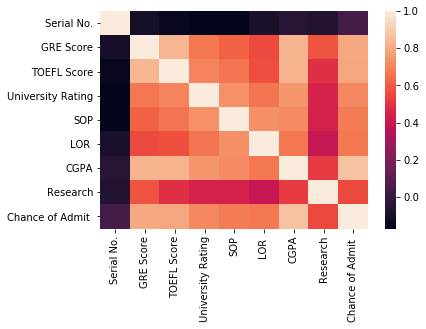

In [16]:
"""Visualización de correlación entre variables. Al evaluar la columna 
de Chance of Admit, se puede ver que hay alta correlación con CGPA, 
TOEFL Score y GRE Score (Estas pueden ser buenas variables predictivas)
Además, se puede ver que hay alta correlación entre SOP y LOR (puede ser
que se vaya a eliminar alguna.) """

core = data_inicial.corr()
sns.heatmap(core)
plt.plot()

## Creación y Evaluación de Modelos

In [18]:
data_inicial.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [19]:
""" Para que el algoritmo de gradient descent no tarde muchas iteraciones en 
converger, es importante normalizar las variables. Se puede resaltar esta 
necesidad al ver que la escala de Chance of Admit es de 0 a 1 y la escala 
de otras variables puede ser desde 0 hasta 350. """

data_normal = data_inicial.copy()
variables = ['GRE Score','TOEFL Score','University Rating','SOP',
             'LOR ','CGPA','Research']

features = data_normal[variables].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
features_n = min_max_scaler.fit_transform(features)
normalizado = pd.DataFrame(features_n, columns=variables)

In [20]:
normalizado.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0.94,0.928571,0.75,0.875,0.875,0.913462,1.0
1,0.68,0.535714,0.75,0.750,0.875,0.663462,1.0
2,0.52,0.428571,0.50,0.500,0.625,0.384615,1.0
3,0.64,0.642857,0.50,0.625,0.375,0.599359,1.0
4,0.48,0.392857,0.25,0.250,0.500,0.451923,0.0


In [21]:
""" Función de automatización de pruebas con modelo lineal simple, 
esta se utilizará para hacer predicciones con una sola variable al inicio."""

costos = []
def simple_model(name, alpha, it, delta, l, total, numero):
    m,_ = data_inicial.shape
    xi = normalizado[name].to_numpy().reshape(m,1)
    yi = data_inicial['Chance of Admit '].to_numpy().reshape(m,1)
    # recibo la data 
    xs = np.hstack((np.ones(m).reshape(m,1), xi))
    # inicializar en 0,0 este caso es especifico de 2 
    thetas = [0,0]
    
    x_train, x_test, y_train, y_test = train_test_split(xs, yi, test_size=0.2, random_state=42)
    res = gd.gradient_descent(x_train, y_train, thetas, alpha, it, delta, l)
    final = res[len(res) - 1][1]
    info = res[len(res) - 1]
    costos.append(res[len(res) - 1][2])
    axtemp = fig.add_subplot(total,1,numero)
    plt.scatter(xi,yi)
    x = np.linspace(0,1,100)
    y = final[1] * x + final[0]
    plt.plot(x, y, '-r')
    plt.title(name)
    plt.xlabel(name)
    plt.ylabel("Chances of Admit")
    plt.show()
    print("RESULTADOS: \nCOSTO TRAIN: ",info[2],
         "\nTHETAS: ", info[1])
    print("COSTO TEST: ", gd.cost(x_test, y_test, final, 0))
    return info

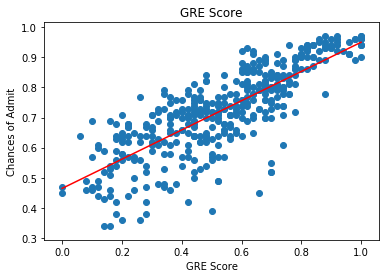

RESULTADOS: 
COSTO TRAIN:  0.003351041427385181 
THETAS:  [[0.46423618]
 [0.48631677]]
COSTO TEST:  0.00466299926725102


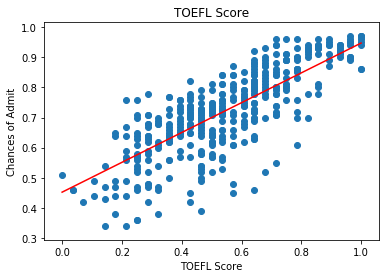

RESULTADOS: 
COSTO TRAIN:  0.0036364163991091727 
THETAS:  [[0.45176434]
 [0.49609381]]
COSTO TEST:  0.004462689032744053


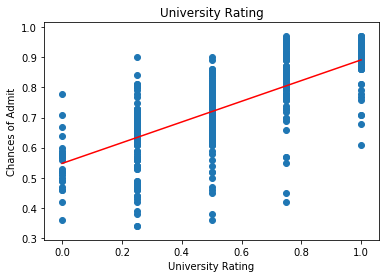

RESULTADOS: 
COSTO TRAIN:  0.004588577970883129 
THETAS:  [[0.5474625 ]
 [0.34434256]]
COSTO TEST:  0.006747714115949213


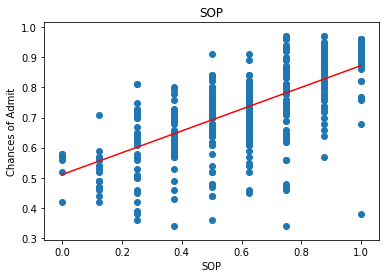

RESULTADOS: 
COSTO TRAIN:  0.005168095918950258 
THETAS:  [[0.51041102]
 [0.36261635]]
COSTO TEST:  0.006983782835770128


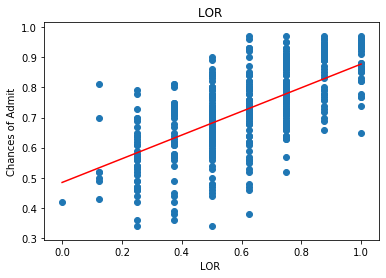

RESULTADOS: 
COSTO TRAIN:  0.005520613539427286 
THETAS:  [[0.48411887]
 [0.39379768]]
COSTO TEST:  0.006003557135948508


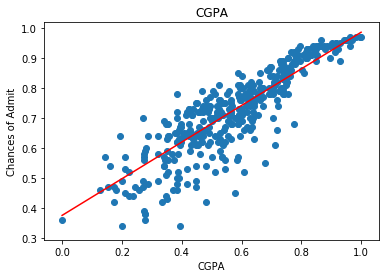

RESULTADOS: 
COSTO TRAIN:  0.0023232767377221247 
THETAS:  [[0.3747828 ]
 [0.61227083]]
COSTO TEST:  0.0029160323279776427
no
867


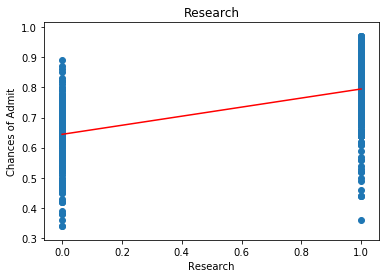

RESULTADOS: 
COSTO TRAIN:  0.006619847064542791 
THETAS:  [[0.64418918]
 [0.15086897]]
COSTO TEST:  0.008765274556320384


In [22]:
"""Loop que recorre todas las variables y prueba hacer 
un modelo con cada una."""

total = len(variables)
iteraciones = [1000, 100, 100, 100, 100, 100, 100]
for i in range(total):
    simple_model(variables[i], 0.1, 1000, 0, 0, total, i + 1)

In [23]:
"""Con los resultados anteriores se puede declarar que la variable 
que mejor predice el resultado es la de CGPA, con un error al hacer 
el test de 0.002916"""

'Con los resultados anteriores se puede declarar que la variable \nque mejor predice el resultado es la de CGPA, con un error al hacer \nel test de 0.002916'

In [24]:
""" Función de automatización para pruebas de modelo con más de una
variable, recibe un arreglo con los nombres de las variables que 
se desean ingresar al modelo. """

def multi_model(df, names, alpha, it, delta, l):
    m,_ = data_inicial.shape
    x = df[names].to_numpy().reshape(m,len(names))
    ys = data_inicial['Chance of Admit '].to_numpy().reshape(m,1)
    # recibo la data 
    xs = np.hstack((np.ones(m).reshape(m,1), x))
    thetas = [0 for i in range(len(names) + 1)]
    
    x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=42)
    res = gd.gradient_descent(x_train, y_train, thetas, alpha, it, delta, l)
    final = res[len(res) - 1]
    c2 = gd.cost(x_test, y_test, final[1],0)
    #print("RESULTADOS: \nCOSTO TRAIN: ", final[2],
    #     "\nCOSTO TEST: ", gd.cost(x_test, y_test, final[1],0))
    costos = [i[2] for i in res]
    iteraciones = [i for i in range(len(res))]
    plt.plot(iteraciones, costos)
    return c2

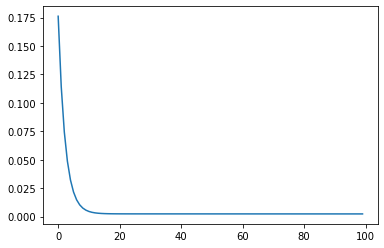

In [25]:
"""Primera prueba al incluir las variables que mejores resultados 
tuvieron al correr juntas. El error resultante es peor que el de 
CGPA individualmente, es decir, 0.002944"""

test1 = ['CGPA','GRE Score','TOEFL Score']
# PROBAR CON LAS 
trace = multi_model(normalizado, test1, 0.1,100,0,0)

RESULTADOS: 
COSTO TRAIN:  0.002290018058760802 
COSTO TEST:  0.00233596477321609


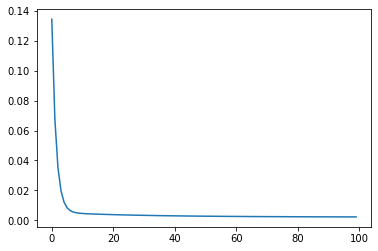

In [47]:
variables = ['GRE Score','TOEFL Score','University Rating',
             'LOR ','CGPA','Research']
trace = multi_model(normalizado, variables, 0.1,100,0,0)

RESULTADOS: 
COSTO TRAIN:  0.0024698153074816692 
COSTO TEST:  0.0024648441764018154


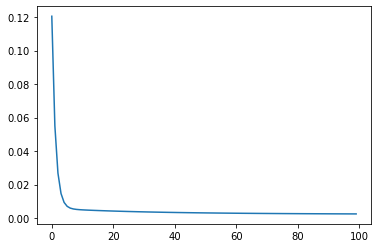

In [52]:
# ESTE VA GANANDO 
trace = multi_model(normalizado, variables, 0.1,100,0,0)

(0.0022139490185644887, ('GRE Score', 'TOEFL Score', 'LOR ', 'CGPA', 'Research'))


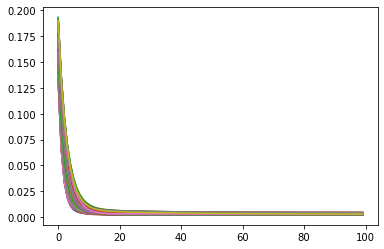

In [22]:
import itertools
variables = ['GRE Score','TOEFL Score','University Rating','SOP',
             'LOR ','CGPA','Research']
test1 = list(itertools.combinations(variables, 6))
test2 = list(itertools.combinations(variables, 5))
test3 = list(itertools.combinations(variables, 4))
test4 = list(itertools.combinations(variables, 3))
test5 = list(itertools.combinations(variables, 2))
total = test1 + test2 + test3 + test4 + test5

costos = []
for i in total:
    resultado = multi_model(normalizado, list(i), 0.1,100,0,0)
    costos.append((resultado, i))
ordenado = sorted(costos)
print(ordenado[0])

In [23]:
# AHORA TOCA VERIFICAR CON FEATURE SCALING 
# probar con GRE score 

data_aumentada = data_inicial.copy()
data_aumentada['GRE2'] = data_aumentada['GRE Score'] ** 2
data_aumentada['GRE3'] = data_aumentada['GRE Score'] ** 3
data_aumentada.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,GRE2,GRE3
0,1,337,118,4,4.5,4.5,9.65,1,0.92,113569,38272753
1,2,324,107,4,4.0,4.5,8.87,1,0.76,104976,34012224
2,3,316,104,3,3.0,3.5,8.00,1,0.72,99856,31554496
3,4,322,110,3,3.5,2.5,8.67,1,0.80,103684,33386248
4,5,314,103,2,2.0,3.0,8.21,0,0.65,98596,30959144


In [24]:
data_aumentada_normal = data_aumentada.copy()
variables = ['GRE Score','TOEFL Score','University Rating','SOP',
             'LOR ','CGPA','Research', 'GRE2', 'GRE3']

features = data_aumentada_normal[variables].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
features_n = min_max_scaler.fit_transform(features)
normalizado_aumentado = pd.DataFrame(features_n, columns=variables)

no
5499
0.004661782018961872


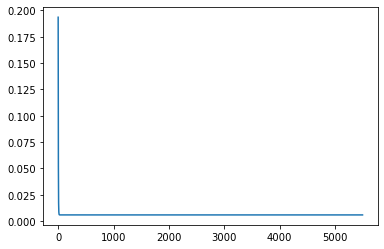

In [30]:
variables = ['GRE Score','GRE2']
trace = multi_model(normalizado_aumentado, variables, 0.1,10000,0,5)
print(trace)

no
5791
0.004664959589282748


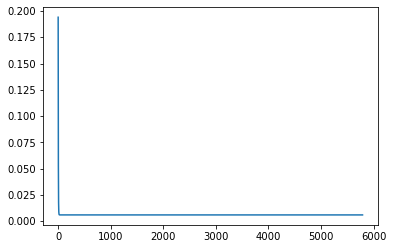

In [31]:
variables = ['GRE Score','GRE3']
trace = multi_model(normalizado_aumentado, variables, 0.1,10000,0,5)
print(trace)

no
6042
0.0022852540176704047


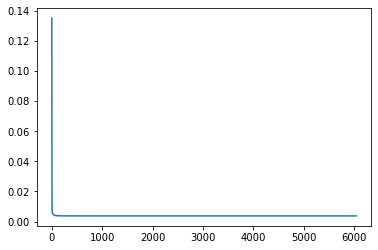

In [35]:
variables = ['GRE Score', 'TOEFL Score', 'LOR ', 'CGPA', 'Research', 'GRE3']
trace = multi_model(normalizado_aumentado, variables, 0.1,10000,0,5)
print(trace)